In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import feather
import datetime
import itertools
from sklearn import preprocessing
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from catboost import Pool
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_Columns', 100)

In [2]:
train_ = pd.read_feather('../inputs/train_cat_feature.f')
print(train_.shape)
test_ = pd.read_feather('../inputs/test_cat_feature.f')
print(test_.shape)

(8359, 982)
(8360, 977)


In [3]:
n_fold = 5

In [4]:
train_.loc[train_['Developer'].isnull(), 'Developer'] = 'None'
train_.loc[train_['Rating'].isnull(), 'Rating'] = 'None'
train_.loc[train_['Genre'].isnull(), 'Genre'] = 'None'
test_.loc[test_['Developer'].isnull(), 'Developer'] = 'None'
test_.loc[test_['Rating'].isnull(), 'Rating'] = 'None'
test_.loc[test_['Genre'].isnull(), 'Genre'] = 'None'

In [5]:
train_.head()

,Name,Platform,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_tbd,User_Score_int,Critic_Score_int,User_Count_log,Year,CE_Platform,CE_Genre,CE_Publisher,CE_Developer,CE_Rating,CE_User_Score_int,CE_Critic_Score_int,TGE_Global_Sales_mean_by_Platform,TGE_Global_Sales_mean_by_Genre,TGE_Global_Sales_mean_by_Rating,TGE_Global_Sales_mean_by_User_Score_int,TGE_Global_Sales_mean_by_Critic_Score_int,TGE_Global_Sales_mean_by_Platform_Genre,TGE_Global_Sales_mean_by_Platform_Rating,TGE_Global_Sales_mean_by_Genre_Rating,TGE_Global_Sales_mean_by_User_Score_int_Platform,TGE_Global_Sales_mean_by_User_Score_int_Genre,TGE_Global_Sales_mean_by_User_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_Platform,TGE_Global_Sales_mean_by_Critic_Score_int_Genre,TGE_Global_Sales_mean_by_Critic_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_User_Score_int,TGE_Global_Sales_std_by_Platform,TGE_Global_Sales_std_by_Genre,TGE_Global_Sales_std_by_Rating,TGE_Global_Sales_std_by_User_Score_int,TGE_Global_Sales_std_by_Critic_Score_int,TGE_Global_Sales_std_by_Platform_Genre,TGE_Global_Sales_std_by_Platform_Rating,TGE_Global_Sales_std_by_Genre_Rating,...,WD_surfer,WD_faction,WD_gears,WD_slug,WD_tenchu,WD_dual,WD_joker,WD_others,WD_rivals,WD_professor,WD_crimson,WD_godzilla,WD_skies,WD_hakusho,WD_prophecy,WD_wings,WD_champion,WD_codename,WD_medieval,WD_town,WD_century,WD_atlantis,WD_scene,WD_rome,WD_dino,WD_groove,WD_volleyball,WD_wario,WD_machi,WD_mirai,WD_studio,WD_bandicoot,WD_director,WD_wall,WD_yoru,WD_kane,WD_west,WD_unreal,WD_turismo,WD_redemption,LDA_Publisher_0,LDA_Publisher_1,LDA_Publisher_2,LDA_Publisher_3,LDA_Publisher_4,LDA_Publisher_5,LDA_Publisher_6,LDA_Publisher_7,LDA_Publisher_8,LDA_Publisher_9
0,LEGO Batman: The Videogame,Wii,Action,Warner Bros. Interactive Entertainment,180,97,0,28,306,74.0,17.0,7.9,22.0,Traveller's Tales,E10+,0,8.0,7.0,3.135494,2010.0,1320,3370,235,77,1420,2830,2019,93.604962,61.883755,49.257785,106.536082,49.231678,59.678899,52.633663,56.848214,289.223684,112.428571,64.319444,81.140351,48.326531,50.646154,56.630137,444.419232,148.275892,72.187084,341.484617,73.847985,96.258706,76.873366,69.018125,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000142,0.000142,0.807465,0.000142,0.000142,0.031338,0.160205,0.000142,0.000142,0.000142
1,LEGO Indiana Jones: The Original Adventures,Wii,Action,LucasArts,151,61,0,21,234,78.0,22.0,6.6,28.0,Traveller's Tales,E10+,0,7.0,8.0,3.367296,2008.0,1320,3370,90,77,1420,1634,2366,96.597250,58.394680,49.148789,66.403374,101.466970,54.090000,48.867470,52.439815,213.160000,54.335079,58.293233,483.589744,89.802260,75.231343,96.758065,462.863031,120.188797,75.206074,174.818593,341.906251,91.001509,72.338596,62.128944,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.039358,0.157024,0.129704,0.000369,0.000369,0.147072,0.075802,0.000369,0.413444,0.036489
2,LEGO Batman: The Videogame,PSP,Action,Warner Bros. Interactive Entertainment,56,44,0,27,128,73.0,5.0,7.4,10.0,Traveller's Tales,E10+,0,7.0,7.0,2.397895,2010.0,1209,3370,235,77,1420,1634,2019,29.606403,59.681720,53.568595,64.981846,46.931655,48.185714,53.033898,58.454936,31.886792,58.615789,60.314286,45.701493,47.107692,53.884615,57.709821,69.859005,132.194405,81.714638,150.222097,77.663440,114.136366,82.460642,74.957223,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000142,0.000142,0.807465,0.000142,0.000142,0.031338,0.160205,0.000142,0.000142,0.000142
3,Combat,2600,Action,Atari,117,7,0,1,125,NaN,NaN,NaN,NaN,None,None,0,NaN,NaN,NaN,1982.0,133,3370,367,6623,6769,9129,8582,65.943662,62.435252,NaN,NaN,NaN,52.269231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.197493,149.649097,NaN,NaN,NaN,49.684249,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.019402,0.159094,0.000091,0.000091,0.000091,0.04607

In [6]:
test_.head()

,Name,Platform,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_tbd,User_Score_int,Critic_Score_int,User_Count_log,Year,CE_Platform,CE_Genre,CE_Publisher,CE_Developer,CE_Rating,CE_User_Score_int,CE_Critic_Score_int,TGE_Global_Sales_mean_by_Platform,TGE_Global_Sales_mean_by_Genre,TGE_Global_Sales_mean_by_Rating,TGE_Global_Sales_mean_by_User_Score_int,TGE_Global_Sales_mean_by_Critic_Score_int,TGE_Global_Sales_mean_by_Platform_Genre,TGE_Global_Sales_mean_by_Platform_Rating,TGE_Global_Sales_mean_by_Genre_Rating,TGE_Global_Sales_mean_by_User_Score_int_Platform,TGE_Global_Sales_mean_by_User_Score_int_Genre,TGE_Global_Sales_mean_by_User_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_Platform,TGE_Global_Sales_mean_by_Critic_Score_int_Genre,TGE_Global_Sales_mean_by_Critic_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_User_Score_int,TGE_Global_Sales_std_by_Platform,TGE_Global_Sales_std_by_Genre,TGE_Global_Sales_std_by_Rating,TGE_Global_Sales_std_by_User_Score_int,TGE_Global_Sales_std_by_Critic_Score_int,TGE_Global_Sales_std_by_Platform_Genre,TGE_Global_Sales_std_by_Platform_Rating,TGE_Global_Sales_std_by_Genre_Rating,TGE_Global_Sales_std_by_User_Score_int_Platform,TGE_Global_Sales_std_by_User_Score_int_Genre,TGE_Global_Sales_std_by_User_Score_int_Rating,TGE_Global_Sales_std_by_Critic_Score_int_Platform,TGE_Global_Sales_std_by_Critic_Score_int_Genre,...,WD_surfer,WD_faction,WD_gears,WD_slug,WD_tenchu,WD_dual,WD_joker,WD_others,WD_rivals,WD_professor,WD_crimson,WD_godzilla,WD_skies,WD_hakusho,WD_prophecy,WD_wings,WD_champion,WD_codename,WD_medieval,WD_town,WD_century,WD_atlantis,WD_scene,WD_rome,WD_dino,WD_groove,WD_volleyball,WD_wario,WD_machi,WD_mirai,WD_studio,WD_bandicoot,WD_director,WD_wall,WD_yoru,WD_kane,WD_west,WD_unreal,WD_turismo,WD_redemption,LDA_Publisher_0,LDA_Publisher_1,LDA_Publisher_2,LDA_Publisher_3,LDA_Publisher_4,LDA_Publisher_5,LDA_Publisher_6,LDA_Publisher_7,LDA_Publisher_8,LDA_Publisher_9
0,Hitman 2: Silent Assassin,XB,Action,Eidos Interactive,84.0,23.0,8.0,19.0,Io Interactive,M,0,8.0,8.0,2.995732,2004.0,824,3370,198,20,1563,2830,2366,28.428571,61.011474,96.410622,100.864791,99.177204,25.973684,50.600000,118.701987,40.721649,103.318681,123.796512,34.246377,90.017778,88.489083,111.091346,64.594512,139.218459,203.600983,320.473808,323.717868,45.034497,128.072262,266.693331,92.540165,208.199887,235.151522,44.125958,95.640508,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.165131,0.200474,0.000168,0.000168,0.000168,0.08752,0.000168,0.011961,0.534073,0.000168
1,Legacy of Kain: Soul Reaver,PS,Action,Eidos Interactive,91.0,17.0,9.0,132.0,Crystal Dynamics,T,0,9.0,9.0,4.890349,1999.0,1197,3370,198,25,2961,1033,760,72.632812,61.011474,50.841880,126.789762,201.134986,72.709091,230.451613,51.920228,325.000000,156.375000,104.608491,412.666667,190.612903,164.576923,215.804348,129.886997,139.218459,99.850190,235.111932,327.145440,108.623828,289.354320,96.611679,360.629311,287.232653,191.872644,328.886578,185.067852,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.165131,0.200474,0.000168,0.000168,0.000168,0.08752,0.000168,0.011961,0.534073,0.000168
2,Metal Gear Solid 2: Substance,XB,Action,Konami Digital Entertainment,87.0,28.0,8.5,39.0,KCEJ,M,0,8.0,9.0,3.688879,2004.0,824,3370,834,12,1563,2830,760,28.428571,61.011474,96.410622,100.864791,201.134986,25.973684,50.600000,118.701987,40.721649,103.318681,123.796512,57.935484,190.612903,201.981308,201.214689,64.594512,139.218459,203.600983,320.473808,327.145440,45.034497,128.072262,266.693331,92.540165,208.199887,235.151522,52.441037,185.067852,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.076232,0.101225,0.009725,0.108554,0.063932,0.00004,0.016500,0.523117,0.058425,0.042250
3,Silent Hill: Homecoming,X360,Action,Konami Digital Entertainment,70.0,54.0,6.9,180.0,Double Helix Games,M,0,7.0,7.0,5.198497,2010.0,

In [7]:
cat_params = {
    'depth' : 6,
    'learning_rate' : 0.01, 
    'eval_metric' :'RMSE', 
    'random_seed' :0,
    'num_boost_round': 10000,
}

In [8]:
categorical_features = ['Platform', 'Genre', 'Developer', 'Rating']

In [9]:
def create_bin_y_folds(X, y):
    num_bins = np.int(1 + np.log2(len(X)))
    print('num_bins: ', num_bins)
    bins = pd.qcut(y, q=num_bins, labels=False)
    kf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = kf.split(X=X, y=bins.values)
    return cv

In [10]:
def create_normal_folds(X, y):
    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = fold.split(X)
    return cv

In [11]:
def train_catboost(X, y, params: dict, verbose=100):

    #   cv = create_normal_folds(X, y)
    cv = create_bin_y_folds(X, y)
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        print('x_train', x_train.shape)
        print('x_valid', x_valid.shape)
        
        train_pool = Pool(data=x_train, 
                                        label=y_train, 
                                        cat_features=categorical_features)
        validate_pool = Pool(data=x_valid, 
                                            label=y_valid, 
                                            cat_features=categorical_features)
        cat_model = CatBoostRegressor(**params)
        cat_model.fit(train_pool, eval_set=validate_pool, 
                                  verbose=verbose, 
                                  use_best_model=True,
                                  early_stopping_rounds=verbose)
        y_pred = cat_model.predict(validate_pool)
        
        oof_pred[idx_valid] = y_pred
        models.append(cat_model)
        print('Fold {} Score: {:.4f}'.format(i, np.sqrt(mean_squared_error(y_valid, y_pred))))

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models, score

In [12]:
def train_catboost_group(X, y, group, params: dict, verbose=100):

    unique_group = group.unique()
    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = fold.split(unique_group)
    
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (tr_group_idx, va_group_idx) in enumerate(cv):
        
        train_groups = unique_group[tr_group_idx]
        valid_groups = unique_group[va_group_idx]
        is_train = group.isin(train_groups)
        is_valid = group.isin(valid_groups)
        
        x_train, y_train = X[is_train], y[is_train]
        x_valid, y_valid = X[is_valid], y[is_valid]
        print('x_train', x_train.shape)
        print('x_valid', x_valid.shape)
        
        train_pool = Pool(data=x_train, 
                                        label=y_train, 
                                        cat_features=categorical_features)
        validate_pool = Pool(data=x_valid, 
                                            label=y_valid, 
                                            cat_features=categorical_features)
        cat_model = CatBoostRegressor(**params)
        cat_model.fit(train_pool, eval_set=validate_pool, 
                                  verbose=verbose, 
                                  use_best_model=True,
                                  early_stopping_rounds=verbose)
        y_pred = cat_model.predict(validate_pool)
        
        oof_pred[is_valid] = y_pred
        models.append(cat_model)
        print('Fold {} Score: {:.4f}'.format(i, np.sqrt(mean_squared_error(y_valid, y_pred))))

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models, score

In [13]:
def train_pred(train_df, y, test_df, group):
#     oof, models, score = train_catboost_group(train_df, y, group, cat_params)
    oof, models, score = train_catboost(train_df, y, cat_params)
    
    pred_list = []
    for model in models:
            test_pool = Pool(data=test_df, cat_features=categorical_features)
            pred = model.predict(test_pool)
            pred = np.expm1(pred)
            pred_list.append(pred)
            print(pred.mean())
            
    pred = np.mean(pred_list, axis=0)
    return pred, score, models

In [14]:
def feat_imp(model):
    fi = model.feature_importance()
    fn = model.feature_name()
    df_feature_importance = pd.DataFrame({'name':fn, 'imp':fi})
    df_feature_importance.sort_values('imp', inplace=True)
    return df_feature_importance

def feature_importance(models):
    fi = pd.DataFrame(columns=['name'])
    for i, model in enumerate(models):
        fi_tmp = feat_imp(model)
        colname = 'imp_{}'.format(i)
        fi_tmp.rename(columns={'imp': colname}, inplace=True)
        fi = pd.merge(fi, fi_tmp, on=['name'], how='outer')
    fi['sum'] = fi.sum(axis=1)
    return fi.sort_values(['sum'], ascending=False)

In [15]:
%%time
y = train_['Global_Sales'].apply(np.log1p)
group = train_['Publisher'].copy()
train_.drop(columns=['Name', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], inplace=True)
test_.drop(columns=['Name', 'Publisher',], inplace=True)
column_cnt = len(train_.columns)
assert train_.shape[1] == test_.shape[1]

pred, score, models = train_pred(train_, y, test_, group)

num_bins:  14
x_train (6687, 975)
x_valid (1672, 975)
0:	learn: 1.3899290	test: 1.3755639	best: 1.3755639 (0)	total: 61.7ms	remaining: 10m 16s
100:	learn: 1.1008076	test: 1.0951616	best: 1.0951616 (100)	total: 1.21s	remaining: 1m 58s
200:	learn: 1.0026188	test: 1.0072830	best: 1.0072830 (200)	total: 2.3s	remaining: 1m 52s
300:	learn: 0.9599130	test: 0.9715880	best: 0.9715880 (300)	total: 3.39s	remaining: 1m 49s
400:	learn: 0.9331022	test: 0.9493393	best: 0.9493393 (400)	total: 4.45s	remaining: 1m 46s
500:	learn: 0.9157066	test: 0.9360569	best: 0.9360569 (500)	total: 5.53s	remaining: 1m 44s
600:	learn: 0.9027819	test: 0.9280773	best: 0.9280773 (600)	total: 6.6s	remaining: 1m 43s
700:	learn: 0.8912787	test: 0.9216320	best: 0.9216320 (700)	total: 7.66s	remaining: 1m 41s
800:	learn: 0.8811147	test: 0.9163268	best: 0.9163268 (800)	total: 8.73s	remaining: 1m 40s
900:	learn: 0.8721692	test: 0.9115757	best: 0.9115757 (900)	total: 9.78s	remaining: 1m 38s
1000:	learn: 0.8629133	test: 0.9072890	b

8900:	learn: 0.5925196	test: 0.8412273	best: 0.8411824 (8868)	total: 1m 35s	remaining: 11.8s
9000:	learn: 0.5908126	test: 0.8409745	best: 0.8409745 (9000)	total: 1m 36s	remaining: 10.7s
9100:	learn: 0.5890021	test: 0.8408010	best: 0.8408010 (9100)	total: 1m 37s	remaining: 9.66s
9200:	learn: 0.5873157	test: 0.8405579	best: 0.8405504 (9196)	total: 1m 38s	remaining: 8.58s
9300:	learn: 0.5856416	test: 0.8405274	best: 0.8405104 (9297)	total: 1m 39s	remaining: 7.51s
9400:	learn: 0.5840468	test: 0.8402995	best: 0.8402827 (9394)	total: 1m 40s	remaining: 6.43s
9500:	learn: 0.5823137	test: 0.8400453	best: 0.8400445 (9499)	total: 1m 42s	remaining: 5.36s
9600:	learn: 0.5804571	test: 0.8398811	best: 0.8398713 (9598)	total: 1m 43s	remaining: 4.29s
9700:	learn: 0.5788393	test: 0.8398358	best: 0.8397521 (9666)	total: 1m 44s	remaining: 3.21s
9800:	learn: 0.5770684	test: 0.8395960	best: 0.8395960 (9800)	total: 1m 45s	remaining: 2.14s
9900:	learn: 0.5756371	test: 0.8393718	best: 0.8393643 (9896)	total: 1

7600:	learn: 0.6166530	test: 0.8447764	best: 0.8447742 (7596)	total: 1m 24s	remaining: 26.5s
7700:	learn: 0.6146787	test: 0.8447051	best: 0.8446708 (7686)	total: 1m 25s	remaining: 25.4s
7800:	learn: 0.6123551	test: 0.8444537	best: 0.8444537 (7800)	total: 1m 26s	remaining: 24.3s
7900:	learn: 0.6103048	test: 0.8442942	best: 0.8442942 (7900)	total: 1m 27s	remaining: 23.2s
8000:	learn: 0.6082963	test: 0.8439443	best: 0.8439443 (8000)	total: 1m 28s	remaining: 22.1s
8100:	learn: 0.6062987	test: 0.8437457	best: 0.8437457 (8100)	total: 1m 29s	remaining: 21s
8200:	learn: 0.6043066	test: 0.8435081	best: 0.8434969 (8199)	total: 1m 30s	remaining: 19.9s
8300:	learn: 0.6024342	test: 0.8434232	best: 0.8434232 (8300)	total: 1m 31s	remaining: 18.8s
8400:	learn: 0.6004601	test: 0.8431517	best: 0.8431424 (8390)	total: 1m 32s	remaining: 17.6s
8500:	learn: 0.5986671	test: 0.8429080	best: 0.8429080 (8500)	total: 1m 33s	remaining: 16.5s
8600:	learn: 0.5965330	test: 0.8426361	best: 0.8426342 (8598)	total: 1m 

6500:	learn: 0.6345228	test: 0.8702313	best: 0.8702313 (6500)	total: 1m 13s	remaining: 39.4s
6600:	learn: 0.6320078	test: 0.8699127	best: 0.8699127 (6600)	total: 1m 14s	remaining: 38.3s
6700:	learn: 0.6292711	test: 0.8694292	best: 0.8694292 (6700)	total: 1m 15s	remaining: 37.2s
6800:	learn: 0.6269794	test: 0.8690031	best: 0.8690031 (6800)	total: 1m 16s	remaining: 36.1s
6900:	learn: 0.6247698	test: 0.8686788	best: 0.8686788 (6900)	total: 1m 17s	remaining: 35s
7000:	learn: 0.6225785	test: 0.8682871	best: 0.8682851 (6996)	total: 1m 19s	remaining: 33.9s
7100:	learn: 0.6204008	test: 0.8680818	best: 0.8680818 (7100)	total: 1m 20s	remaining: 32.8s
7200:	learn: 0.6182432	test: 0.8678459	best: 0.8678171 (7180)	total: 1m 21s	remaining: 31.6s
7300:	learn: 0.6161179	test: 0.8675615	best: 0.8675615 (7300)	total: 1m 22s	remaining: 30.5s
7400:	learn: 0.6143084	test: 0.8673477	best: 0.8673477 (7400)	total: 1m 23s	remaining: 29.4s
7500:	learn: 0.6121587	test: 0.8669418	best: 0.8669418 (7500)	total: 1m 

5200:	learn: 0.6865967	test: 0.8337722	best: 0.8337722 (5200)	total: 55.9s	remaining: 51.6s
5300:	learn: 0.6837807	test: 0.8331184	best: 0.8331184 (5300)	total: 57s	remaining: 50.5s
5400:	learn: 0.6812142	test: 0.8325164	best: 0.8325164 (5400)	total: 58.1s	remaining: 49.5s
5500:	learn: 0.6784805	test: 0.8319082	best: 0.8319082 (5500)	total: 59.1s	remaining: 48.4s
5600:	learn: 0.6759292	test: 0.8311848	best: 0.8311848 (5600)	total: 1m	remaining: 47.3s
5700:	learn: 0.6734034	test: 0.8306712	best: 0.8306672 (5698)	total: 1m 1s	remaining: 46.2s
5800:	learn: 0.6707656	test: 0.8301205	best: 0.8301058 (5797)	total: 1m 2s	remaining: 45.1s
5900:	learn: 0.6681862	test: 0.8296707	best: 0.8296707 (5900)	total: 1m 3s	remaining: 44.1s
6000:	learn: 0.6655776	test: 0.8290917	best: 0.8290917 (6000)	total: 1m 4s	remaining: 43s
6100:	learn: 0.6629350	test: 0.8283899	best: 0.8283899 (6100)	total: 1m 5s	remaining: 42s
6200:	learn: 0.6605183	test: 0.8279059	best: 0.8279059 (6200)	total: 1m 6s	remaining: 40.

3900:	learn: 0.7169898	test: 0.8495396	best: 0.8495396 (3900)	total: 42.7s	remaining: 1m 6s
4000:	learn: 0.7137129	test: 0.8486187	best: 0.8486187 (4000)	total: 43.7s	remaining: 1m 5s
4100:	learn: 0.7107023	test: 0.8477280	best: 0.8477280 (4100)	total: 44.8s	remaining: 1m 4s
4200:	learn: 0.7077472	test: 0.8471554	best: 0.8471360 (4197)	total: 45.9s	remaining: 1m 3s
4300:	learn: 0.7046509	test: 0.8464329	best: 0.8464277 (4295)	total: 47s	remaining: 1m 2s
4400:	learn: 0.7018367	test: 0.8459544	best: 0.8459275 (4398)	total: 48s	remaining: 1m 1s
4500:	learn: 0.6988066	test: 0.8451499	best: 0.8451499 (4500)	total: 49.1s	remaining: 1m
4600:	learn: 0.6958371	test: 0.8444438	best: 0.8444438 (4600)	total: 50.2s	remaining: 58.9s
4700:	learn: 0.6926754	test: 0.8440651	best: 0.8440651 (4700)	total: 51.3s	remaining: 57.8s
4800:	learn: 0.6896717	test: 0.8434823	best: 0.8434765 (4797)	total: 52.4s	remaining: 56.8s
4900:	learn: 0.6865480	test: 0.8428215	best: 0.8428136 (4892)	total: 53.5s	remaining: 5

In [16]:
# feature_importance(models).head(50)

In [17]:
df_pred = pd.DataFrame(pred, columns=['Global_Sales'])
df_pred.loc[df_pred['Global_Sales'] < 1, 'Global_Sales'] = 0
print(df_pred.shape)
pred_mean = df_pred['Global_Sales'].mean()
pred_max = df_pred['Global_Sales'].max()
print('mean=', pred_mean)
print('max=', pred_max)
assert len(df_pred) == len(test_)

(8360, 1)
mean= 25.649388065917396
max= 565.9406177733114


Text(0.5, 0, 'Global_Sales')

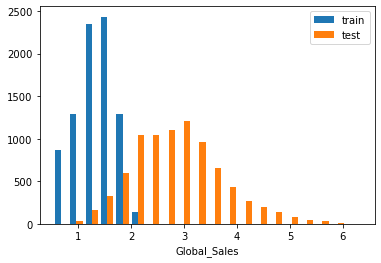

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist([np.log1p(y), np.log1p(df_pred['Global_Sales'])], bins=20, label=['train', 'test'])
ax.legend()
ax.set_xlabel('Global_Sales')

In [19]:
FILENAME = 'submission_cat.csv'
OUTPUT_DIR = '../outputs/'
filepath = os.path.join(OUTPUT_DIR, FILENAME)
df_pred.to_csv(filepath, index=False)
print(filepath)

../outputs/submission_cat.csv


In [20]:
print('- feat =', column_cnt)
print('- mean = {:.4f}'.format(pred_mean))
print('- max = {:.4f}'.format(pred_max))
print('- cat = {:.4f}'.format(score))

- feat = 975
- mean = 25.6494
- max = 565.9406
- cat = 0.8364


#### 30cat
- feat = 975
- mean = 25.6494
- max = 565.9406
- cat = 0.8364
- LB = 

#### 29cat: Name減らす
- feat = 985
- mean = 22.4455
- max = 512.4205
- cat = 0.8316
- LB = 

#### 28cat: groupKfold -> StratifiedKFold
- feat = 1431
- mean = 25.0991
- max = 696.4872
- cat = 0.8369
- LB = 0.9006

#### 27cat
- feat = 1431
- mean = 23.7676
- max = 432.5676
- cat = 1.0556

#### 26cat
- feat = 1442
- mean = 21.8695
- max = 382.0561
- cat = 1.0572

#### 25cat
- feat = 1432
- mean = 24.9464
- max = 505.2158
- cat = 1.0565

#### 23cat
- feat = 1452
- mean = 16.5429
- max = 335.4926
- cat = 1.0367

#### 22cat: catboost
- feat = 1432
- mean = 24.2944
- max = 516.1847
- cat = 1.0980

#### 21cat: catboost (learning_rate=0.01)
- feat = 1421
- mean = 24.3766
- max = 526.5783
- score = 1.0733
- LB= 0.9055

#### 20cat: catboost
- feat = 1421
- mean = 24.6113
- max = 362.5455
- score = 1.1017
- LB= 0.929

#### 20lgbm
- feat = 1421
- mean = 24.6853
- max = 532.8670
- score = 1.0875

#### 11: target_encでUser_Score/Critic_Score
- feat = 1420
- mean = 23.8047
- max = 489.9664
- score = 1.0795
- LB= 0.9001　★best★